In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import load_iris
import pandas as pd
import numpy  as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
%matplotlib inline
!pip3 install netgraph
from netgraph import Graph
!pip install fdeb
from fdeb import fdeb
import matplotlib.collections as collections
import math
from sklearn.decomposition import PCA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.7/96.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.6/305.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.0 MB/s eta 0:00:00


In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
X_train, X_test = X_train / 255.0, X_test / 255.0

# Flatten pixels
X_train = X_train.reshape((-1, 784))
X_test = X_test.reshape((-1, 784))

In [4]:
# tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=784),
    # tf.keras.layers.Conv2D(4, 4)
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=3, batch_size=1, verbose=1)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {accuracy:.4f}')


Epoch 1/3
60000/60000 [==============================] - 151s 2ms/step - loss: 0.4981 - accuracy: 0.8529
Epoch 2/3
60000/60000 [==============================] - 141s 2ms/step - loss: 0.3256 - accuracy: 0.9086
Epoch 3/3
60000/60000 [==============================] - 121s 2ms/step - loss: 0.2973 - accuracy: 0.9181
Test accuracy: 0.9147


In [ ]:
# #This cell gets the input and output names for the first and last layer
# input_names = enumerate(iris["feature_names"])
# ind_input_names = {}

# for i, name in input_names:
#   ind_input_names[i] = name.split()[0] + ' ' + name.split()[1]

# target_names = enumerate(iris["target_names"])

# ind_output_names = {}

# for i, name in target_names:
#   ind_output_names[i] = name
# ind_output_names

### Arbitrarily ordered Graph

In [10]:
# Assuming you have Ws defined earlier, and Ws[-1] contains W1 and W2
# Define the weight matrices (taken from Ws[-1])
weights = model.weights
# Create a directed graph
G = nx.DiGraph()

pos = {}

i = 0
z = 0
maxRows = 0
for z in range(len(weights)):
  maxRows = max(maxRows, weights[z].shape[0])
  z += 2

maxRows += 1

colSize = [] #put in to allow for edge_label placement

col = 0
while i < len(weights):
  w = weights[i] #w are weights associated between two layers
  colSize.append(w.shape[0])  #puts size of dest column in the list, helps with edge label positioning

  for sourceRow in range(w.shape[0]):

    # if col == 0: # makes the first layer of nodes' names input the variables
    #   # rows and columns are kept in the name to help with determining pos
    #   source_node = ind_input_names[sourceRow] + '_' + str(sourceRow) + '_' + str(col)
    # else: #Used for every layer but the first
    source_node = 'l_' + str(sourceRow) + '_' + str(col)

    # w.shape[0] is the length of the source column
    pos[source_node] = (col, maxRows/(w.shape[0] + 1) * (sourceRow + 1) * -5) # zero div prevented

    for row in range(w.shape[1]):
      # if (col + 1) == len(weights)//2: # if we are at the last layer, node names are made to be the output
      #   dest_node = ind_output_names[row] + '_' + str(row) + '_' + str(col + 1)
      # else:
      dest_node = 'l_' + str(row) + '_' + str(col+1)

      G.add_edge(source_node, dest_node, weight = w[sourceRow][row])
      # w.shape[1] is length of the destination column
      pos[dest_node] = (col + 1, maxRows/(w.shape[1] + 1) * (row + 1) * -5)  #zero div prevented

  i += 2 # necessary to increment by 2 when using tensor flow
  col += 1

In [11]:
# for node in G.nodes():
#   col = int(node.split('_')[2])
#   if col != 0:

#   else:
#     node_size.append(1000)


In [12]:

  #for node size = neurons output
# node_size = []
# for node in G.nodes:
#   col = int(node.split('_')[2]) - 1
#   if col != -1: #edit for midpoints
#     row = int(node.split('_')[1])
#     intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index = col).output)
#     intermediate_output = intermediate_layer_model(X_test[:1])
#     node_size.append((intermediate_output[0][row] + 1) * 300)
#   else:
#     node_size.append(300)

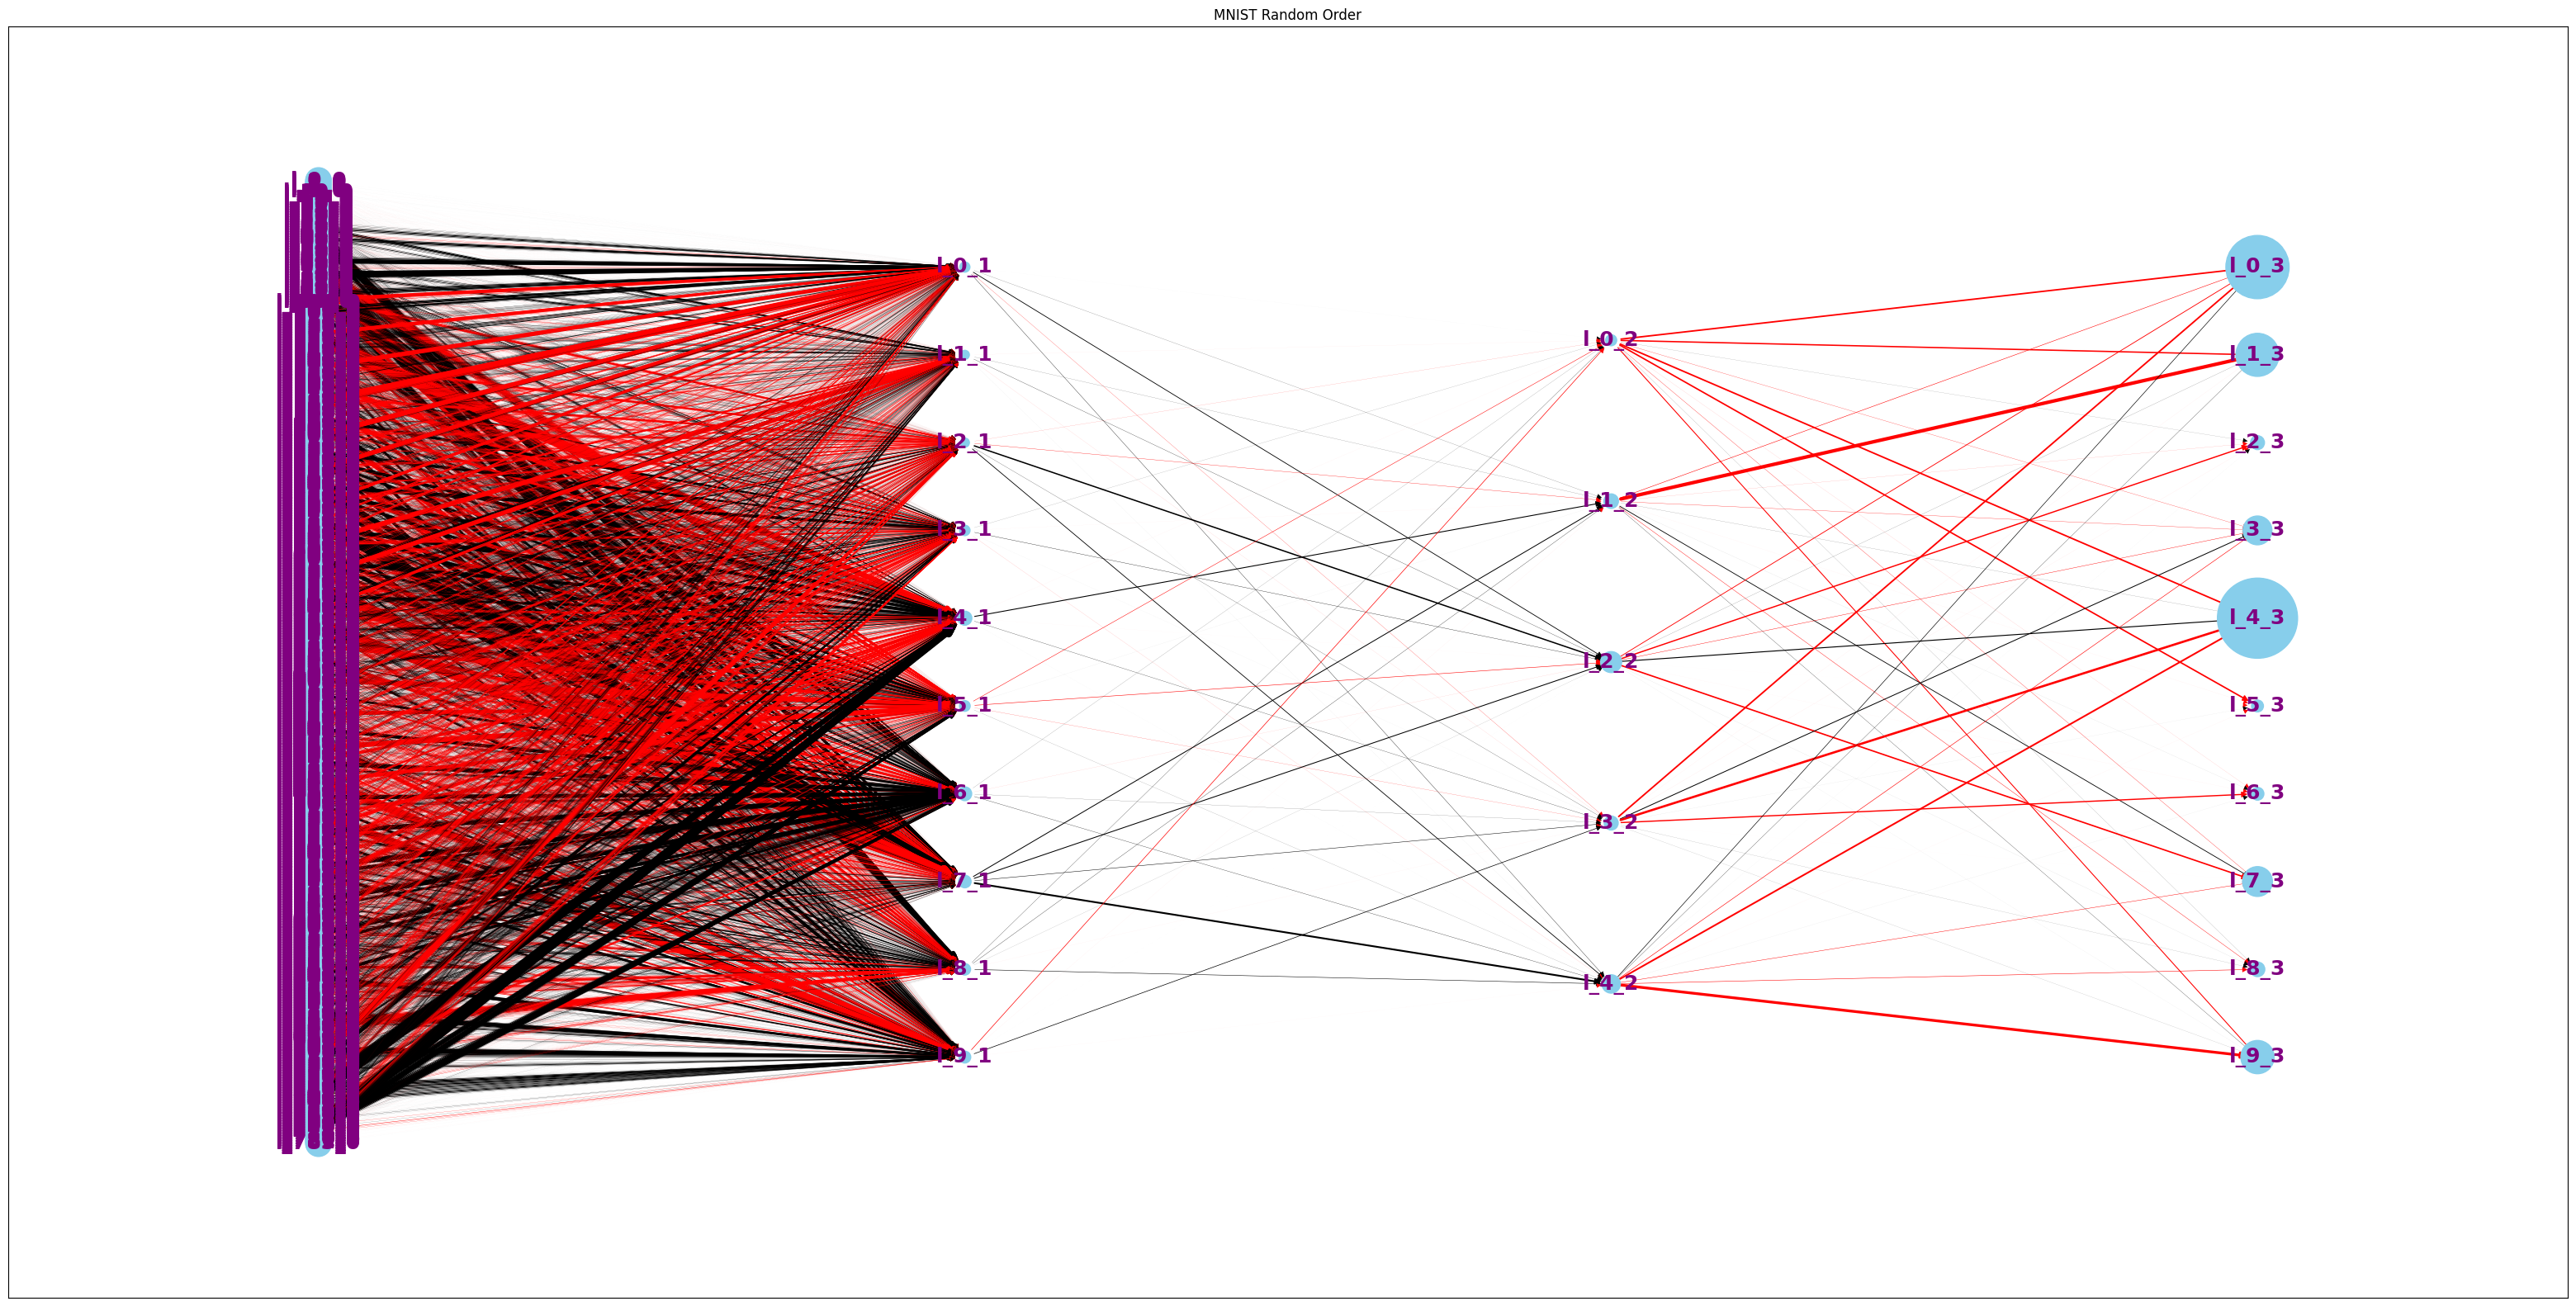

In [13]:
edge_colors = []
alpha = []
width = [] #width is defined here

node_size = []
dest_node_size = {}

for u, v, d in G.edges(data=True):
    if d['weight'] > 0:
        edge_colors.append('black')
    else:
        edge_colors.append('red')

    dest_node_size[v] =  dest_node_size.get(v, 0) + abs(d['weight'])
    alpha.append(d['weight'])
    width.append(d['weight'] ** 2) #thickness squared

#node size
for node in G.nodes():
  if node in dest_node_size.keys():
    col = int(node.split('_')[2]) - 1
    node_size.append((dest_node_size[node]/colSize[col] + 1) ** 9 * 10)
  else:
    node_size.append(500)

plt.figure(figsize=(40, 20))

#handles: nodes, node size, node color,
nx.draw_networkx_nodes(G, pos=pos, node_size=node_size, node_color='skyblue')

#handles edges, edge thickness, and edge color
nx.draw_networkx_edges(G, pos=pos, edge_color=edge_colors, arrows=True, width = width)

# key = edge and val = weight
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
# # handles edge labels pos
# for u, v in G.edges():
#     specific_edge_labels = {(u, v): edge_labels[(u, v)]}
#     row = int(u.split('_')[1])
#     index = int(u.split('_')[2])
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=specific_edge_labels, font_color='black', font_size=12, label_pos = (row + 1) / (colSize[index]+2))

#handles node labels
nx.draw_networkx_labels(G, pos, font_size=18, font_color='purple', font_weight='bold')

plt.title('MNIST Random Order')

plt.axis('on')
plt.margins(0.1)

plt.show()

In [14]:
springPos = nx.spring_layout(G, weight = 'weight', k = 1, iterations = 500)
# nx.draw_networkx_edges(G, pos = springPos, edge_color = edge_colors);
# nx.draw_networkx_nodes(G, pos = springPos);
# nx.draw_networkx_labels(G, pos, font_size=8, font_color='purple', font_weight='bold')
# plt.title("Spring graph");

In [15]:
#puts the spring coordinates into a dataframe
springPos = pd.Series(springPos)
xVals, yVals = zip(*springPos)
coordsS = pd.DataFrame({
    'xVals' : xVals,
    'yVals' : yVals
})

#associates the coords with their nodes
coordsS.index = list(G.nodes())

#combines the x and y coordinates into 1 values
pca = PCA(n_components=1)
y_pca = pca.fit_transform(coordsS)
coordsS = pd.DataFrame({
    'coords' : y_pca.flatten()
    })

#associates the coords with their nodes
coordsS.index = list(G.nodes())
#associates each node and y-val with a column
coordsS['column'] = coordsS.apply(lambda x: x.name.split('_')[2], axis = 1)

# sorts the nodes by columns and then pca values
sorted_groups = coordsS.groupby('column', group_keys=False).apply(lambda x: x.sort_values('coords'))
sorted_groups['group_index'] = sorted_groups.groupby('column').cumcount() #makes sorted values as group index

NN dynamic layout graph based on Spring

In [16]:
weights = model.weights
# Create a directed graph
G = nx.DiGraph()

pos = {}
maxRow = sorted_groups['group_index'].max() + 2
col    = 0
i      = 0
while i < len(weights):
  w = weights[i] #w are weights associated with a col
  for sourceRow in range(w.shape[0]):
    # if col == 0: #if node is in the first layer, it makes the name the input val
    #   source_node = ind_input_names[sourceRow] + '_' + str(sourceRow) + '_' + str(col)
    # else:
    source_node = 'l_' + str(sourceRow) + '_' + str(col)

    if source_node not in pos.keys():
      sourceColumn = sorted_groups.loc[source_node]['column']
      colLength = (int(sorted_groups[sorted_groups['column'] \
        == sourceColumn]['group_index'].max()) + 2)
      currRow = (sourceRow + 1)

      pos[source_node] = (col, maxRow/colLength * currRow)

    for row in range(w.shape[1]):
      # if (col + 1) == len(weights)//2: # makes last layer node names = the output values
      #   dest_node = ind_output_names[row] + '_' + str(row) + '_' + str(col + 1)
      # else:
      dest_node = 'l_' + str(row) + '_' + str(col+1)

      G.add_edge(source_node, dest_node, weight = w[sourceRow][row])
      if dest_node not in pos.keys(): #gives pos if needed
        destColumn = sorted_groups.loc[dest_node]['column']
        colLength = (int(sorted_groups[sorted_groups['column'] \
          == destColumn]['group_index'].max()) + 2)
        currRow = sorted_groups.loc[dest_node]['group_index'] + 1

        pos[dest_node] = (col + 1, maxRow/colLength * currRow)

  i += 2
  col += 1

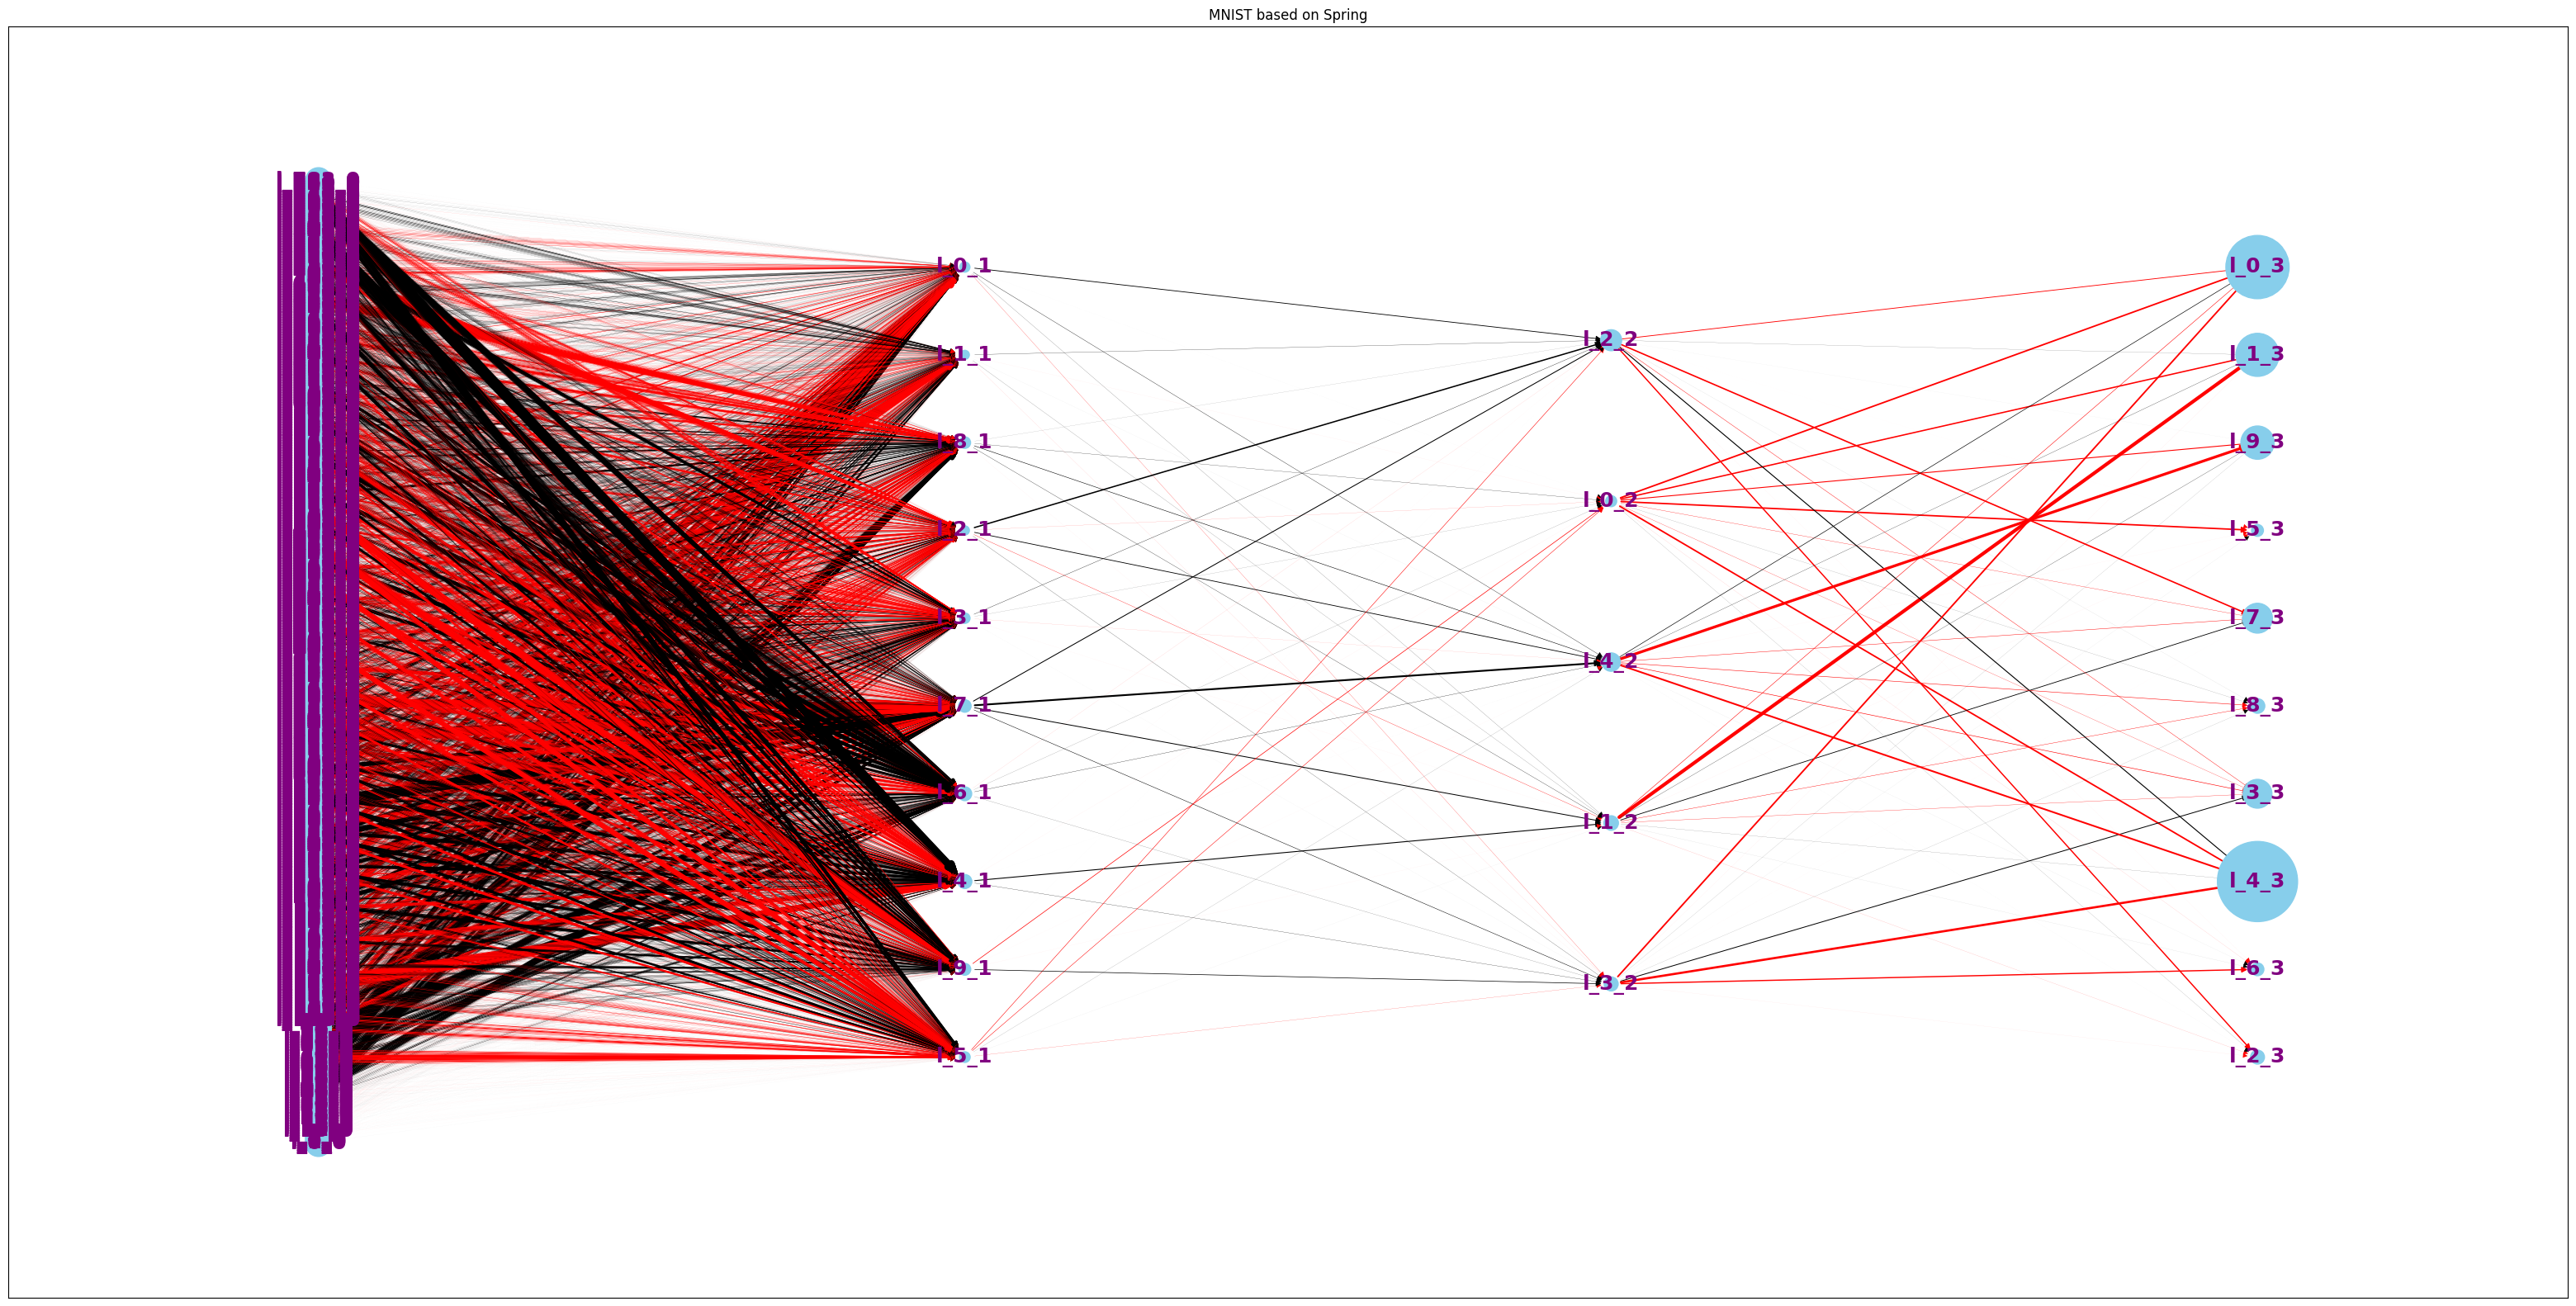

In [17]:
plt.figure(figsize=(40, 20))

#nodes, nodes size, and node color
nx.draw_networkx_nodes(G, pos=pos, node_size=node_size, node_color='skyblue')

#edges, edge color, and edge width
nx.draw_networkx_edges(G, pos=pos, edge_color=edge_colors, arrows=True, width = width)


edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
# # edge labels and their positioning
# for u, v in G.edges():
#     specific_edge_labels = {(u, v): edge_labels[(u, v)]}
#     row = int(u.split('_')[1])
#     index = int(u.split('_')[2])
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=specific_edge_labels, font_color='black', font_weight = 'bold', font_size=12, label_pos = (row + 1) / (colSize[index]+2))

#node names
nx.draw_networkx_labels(G, pos, font_size=18, font_color='purple', font_weight='bold')

plt.title('MNIST based on Spring')

plt.axis('on')
plt.margins(0.1)

plt.show()

### FDEB

In [18]:
#gets rid of input layer
maxRow = sorted_groups['group_index'].max() + 2
nodes_to_exclude = [node for node in G.nodes() if node.endswith("_0")]
G.remove_nodes_from(nodes_to_exclude)

for node in nodes_to_exclude:
  del pos[node]

#node size = weight
node_size = []
for node in G.nodes():
  if node in dest_node_size.keys():
    col = int(node.split('_')[2]) - 1
    node_size.append((dest_node_size[node]/colSize[col] + 1) ** 9 * 10)

  #node size = neuron output
# node_size = []
# for node in G.nodes:
#   col = int(node.split('_')[2]) - 1
#   if col != -1: #edit for midpoints
#     row = int(node.split('_')[1])
#     intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index = col).output)
#     intermediate_output = intermediate_layer_model(X_test[:1])
#     node_size.append((intermediate_output[0][row] + 1) * 300)
#   else:
#     node_size.append(300)


# for key, val in pos.items():
#   if key in sorted_groups.index:
#     row = int(key.split('_')[1])
#     col = sorted_groups.loc[key]['column']
#     colLength = (int(sorted_groups[sorted_groups['column'] \
#       == col]['group_index'].max()) + 2)
#     currRow = (row + 1)

#     y_val = maxRow/colLength * currRow
#     pos[key] = (val[0], y_val)

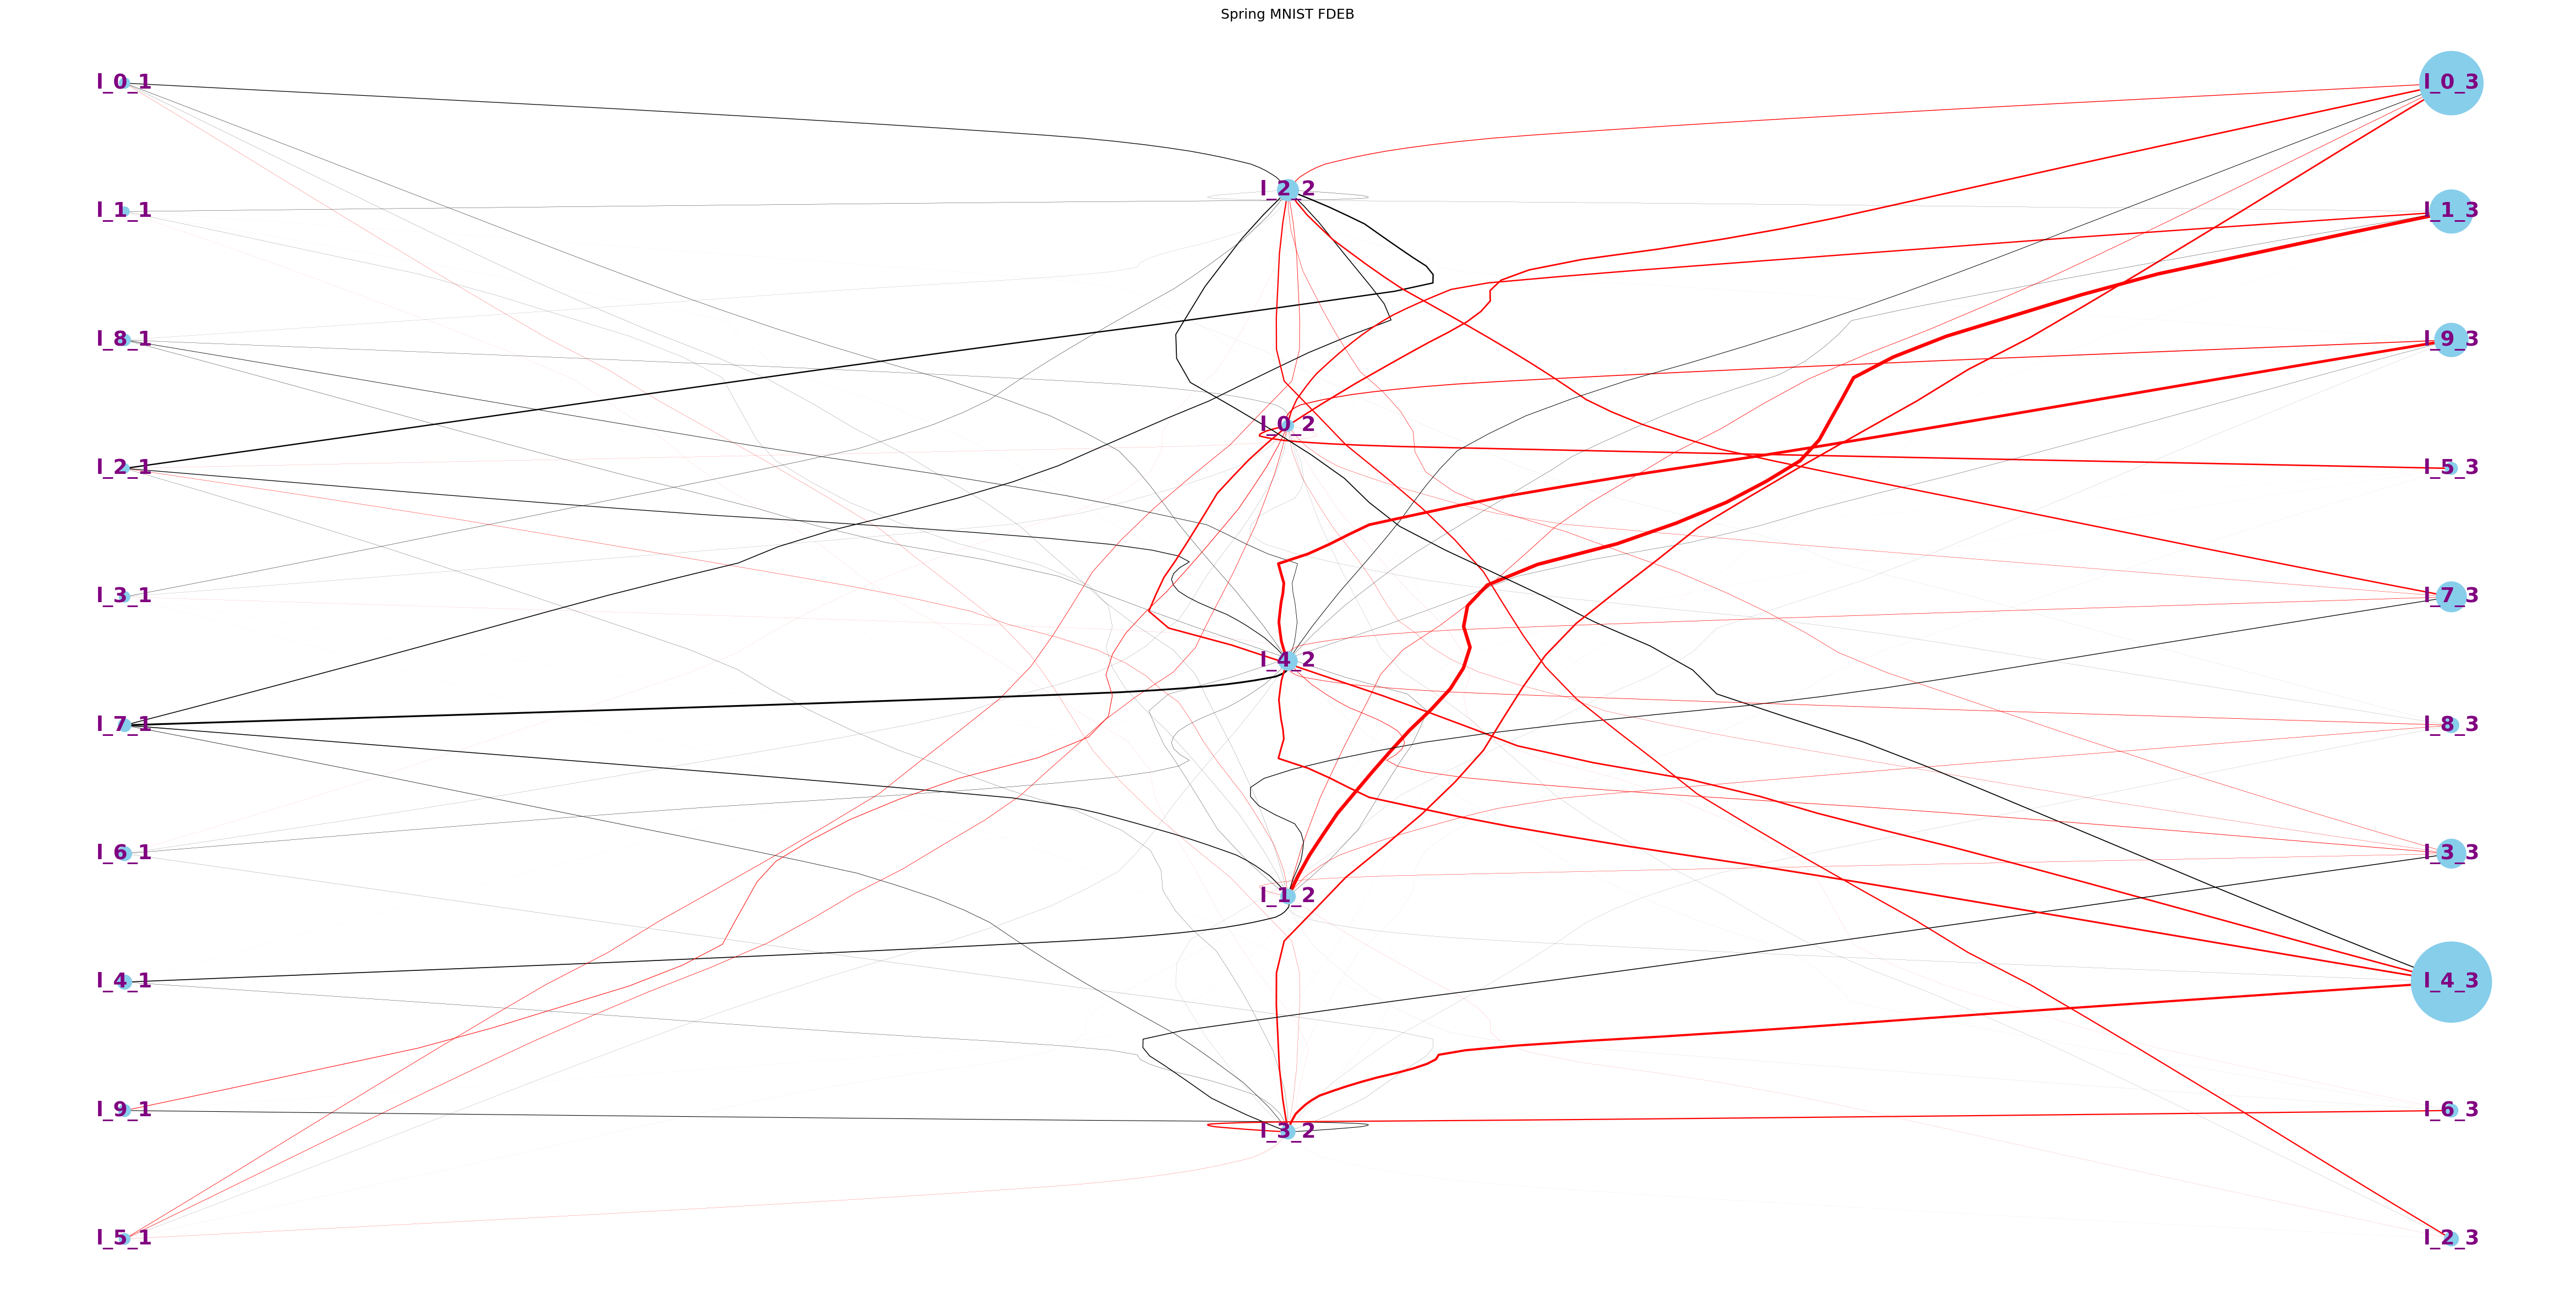

In [19]:
x = np.array(list(pos.values())) # gets the positions
adj = nx.to_scipy_sparse_array(G).tocoo() #makes adjacency matrix
weights = adj.data #gets the weigths

# Extract edges from embedding and adjacency matrix
edges = np.stack([x[adj.row], x[adj.col]], axis=1)

# Compute FDEB
edges_fdeb = fdeb(edges) #bundles edges

fig, ax = plt.subplots(figsize=(40, 20), dpi=150)

# Gets correct colors and line widths
for edge, weight in zip(edges_fdeb, weights):
    if weight >= 0:
      line = collections.LineCollection([edge], color="black", linewidth=weight ** 2, alpha=1)
    else:
      line = collections.LineCollection([edge], color="red", linewidth=weight ** 2, alpha=1)
    ax.add_collection(line)

#node names
nx.draw_networkx_labels(G, pos, font_size=18, font_color='purple', font_weight='bold')


nx.draw_networkx_nodes(G, pos=pos, node_size=node_size, node_color='skyblue')


plt.title('Spring MNIST FDEB')

# Hide axes
ax.axis('off')

plt.show()

### ChatGPTs attempt at making FDEB useful

In [20]:
# # Function to preprocess edges for edge bundling
# # essentially, it trys to add a point in the middle of the edges, which will
# # cause for better attraction, it was also trying (and failing) to factor in weights
# def preprocess_edges(edges, node_positions):
#     bundled_edges = []
#     bundled_weights = []
#     for target_node in G.nodes():
#         incoming_edges = [edge for edge in edges if edge[1] == target_node] #gets edges that share the dest/target node
#         if len(incoming_edges) <= 1:
#             continue

#         mean_position = np.mean([pos[edge[0]] for edge in incoming_edges], axis=0) # averages the positions of the source nodes

#         # Move control points towards the mean position
#         for edge in incoming_edges:
#             source = pos[edge[0]]
#             target = pos[edge[1]]
#             control_points = [source, mean_position, target]
#             bundled_edges.append(control_points) # attempts to use those three points in the FDEB along with the weights
#             bundled_weights.append(G[edge[0]][edge[1]]['weight'])  # makes an array of the weights

#     return np.array(bundled_edges), np.array(bundled_weights)

# # Preprocess edges for bundling
# edges = list(G.edges())
# bundled_edges, bundled_weights = preprocess_edges(edges, pos)

# # Perform edge bundling with FDEB
# edges_fdeb = fdeb(bundled_edges) #, bundled_weights) #took this off because the linear algebra math wasn't mathing, probably fixable tbh

# plt.figure(figsize=(40, 20))

# # adds edge colors and thickness
# for edge, weight in zip(edges_fdeb, bundled_weights):
#     if weight>=0:
#       line = collections.LineCollection([edge], color='black', linewidth=weight ** 2)
#     else:
#       line = collections.LineCollection([edge], color='red', linewidth=weight ** 2)
#     plt.gca().add_collection(line)

# # nodes, node color, and node size
# nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')

# # node names
# nx.draw_networkx_labels(G, pos, font_size=12, font_color='purple', font_weight='bold')

# plt.title('Spring Iris FDEB with mean values')
# plt.axis('off')
# plt.show()


### NetGraph attempt at bundling

In [21]:
# node_to_community = {}
# for node in G.nodes():
#   node_to_community[node] = int(node.split('_')[2])

In [22]:
# #adds node color based on community
# community_to_color = {
#     0 : 'tab:blue',
#     1 : 'tab:orange',
#     2 : 'tab:green',
#     3 : 'tab:red',
# }
# node_color = {node: community_to_color[community_id] \
#               for node, community_id in node_to_community.items()}

In [23]:
# # A dictionary where key = edge and val = np.array(weight)
# width = {edge: np.array(G[edge[0]][edge[1]]['weight']).item() for edge in G.edges()}

# edge_colors = {edge: 'black' if np.array(G[edge[0]][edge[1]]['weight']).item() >= 0 else 'red' for edge in G.edges()}

# edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}

# pos2 = {} # Makes a dictionary where key = node and val = np.array(x, y)
# for node, val in pos.items():
#   pos2[node]= np.array([val[0], val[1]])

# # Use the edge_layout option to bundle the edges together
# fig, ax = plt.subplots(figsize = (40, 20))
# Gbundle = Graph(G,
#       node_color=node_color,
#       # node_size = 10,
#       edge_width = width,
#       edge_color = edge_colors,
#       node_layout=pos2,
#       edge_labels = edge_labels,
#       # node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
#       edge_layout='bundled', # this is where bundling is made possible,
#       node_labels = True,
#       edge_alpha = 1,
#       ax=ax,
# )
# # Gbundle.node_positions =
# plt.show()


### Midpoints

In [24]:
#create midpoints between columns with white nodes. the y val of the midpt is based on the output node

weights = model.weights
# Create a Multi Drected graph
G = nx.MultiDiGraph()

pos = {}
col = 0
mdpt_weights = {}

i = 0
while i < len(weights): #gets weights associated with the a column
  w = weights[i] #ws are weights between two layers

  for sourceRow in range(w.shape[0]):
    # if col == 0: # makes the first layer of nodes' names input the variables
    #   # rows and columns are kept in the name to help with determining pos
    #   source_node = ind_input_names[sourceRow] + '_' + str(sourceRow) + '_' + str(col)
    # else:
    source_node = 'l_' + str(sourceRow) + '_' + str(col)

    if source_node not in pos.keys():

      sourceColumn = sorted_groups.loc[source_node]['column']
      colLength = (int(sorted_groups[sorted_groups['column'] \
        == sourceColumn]['group_index'].max()) + 2)
      currRow = (sourceRow + 1)

      pos[source_node] = (col, maxRow/colLength * currRow * 5)

    for row in range(w.shape[1]): #w.shape[1] is number of rows in next column

      midpt = 'mp_' + str(row) + '_' + str(col + 1)
      if not G.has_edge(source_node, midpt): #neccessary as this is a multigraph
        G.add_edge(source_node, midpt, weight = np.array(w[sourceRow][row]).item())

      # if col+1 == len(weights)//2: #if last layer, makes node names the output variables
      #   dest_node = ind_output_names[row] + '_' + str(row) + '_' + str(col + 1)
      # else:
      dest_node = 'l_' + str(row) + '_' + str(col + 1)

      if dest_node not in pos.keys():
        destColumn = sorted_groups.loc[dest_node]['column']
        colLength = (int(sorted_groups[sorted_groups['column'] \
          == destColumn]['group_index'].max()) + 2)
        currRow = sorted_groups.loc[dest_node]['group_index'] + 1
        pos[dest_node] = (col + 1, (maxRow/colLength * currRow) * 5)

      if midpt not in pos.keys():
        pos[midpt] = (col + .5, maxRow/colLength * currRow * 5)

      #adds up the total pos and neg weights from mdpt to dest nodes
      edge_weight = np.array(w[sourceRow][row]).item()
      mdpt_weights.setdefault(midpt, (0, 0)) # dictionary: keys = midpt nodes, vals = coords

      positive_weight = mdpt_weights[midpt][0]
      negative_weight = mdpt_weights[midpt][1]

      if edge_weight >= 0:
        positive_weight += edge_weight
      else:
        negative_weight += edge_weight

      mdpt_weights[midpt] = (positive_weight, negative_weight)

  i += 2
  col += 1

for key, val in mdpt_weights.items():
  #renames last layer to be output names
  # if int(key.split('_')[2]) == len(weights)//2:
  #   dest_node = ind_output_names[int(key.split('_')[1])] + '_' + key.split('_')[1] + '_' + key.split('_')[2]
  # else:
  dest_node = 'l_' + key.split('_')[1] + '_' + key.split('_')[2]

  # makes the two edges (pos and neg) btwn mdpt and actual layers, if either pos or neg or 0 doens't do it
  if val[0] != 0:
    G.add_edge(key, dest_node, weight = float(val[0])) # positive weight
  if val[1] != 0:
    G.add_edge(key, dest_node, weight = float(val[1])) # negative weight

In [25]:
    #node size = neuron output
# node_size = []
# for node in G.nodes:
#   if node[:2] == 'mp':
#     continue
#   col = int(node.split('_')[2]) - 1
#   if col != -1: #edit for midpoints
#     row = int(node.split('_')[1])
#     intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index = col).output)
#     intermediate_output = intermediate_layer_model(X_test[:1])
#     node_size.append((intermediate_output[0][row] + 1) * 300)
#   else:
#     node_size.append(300)

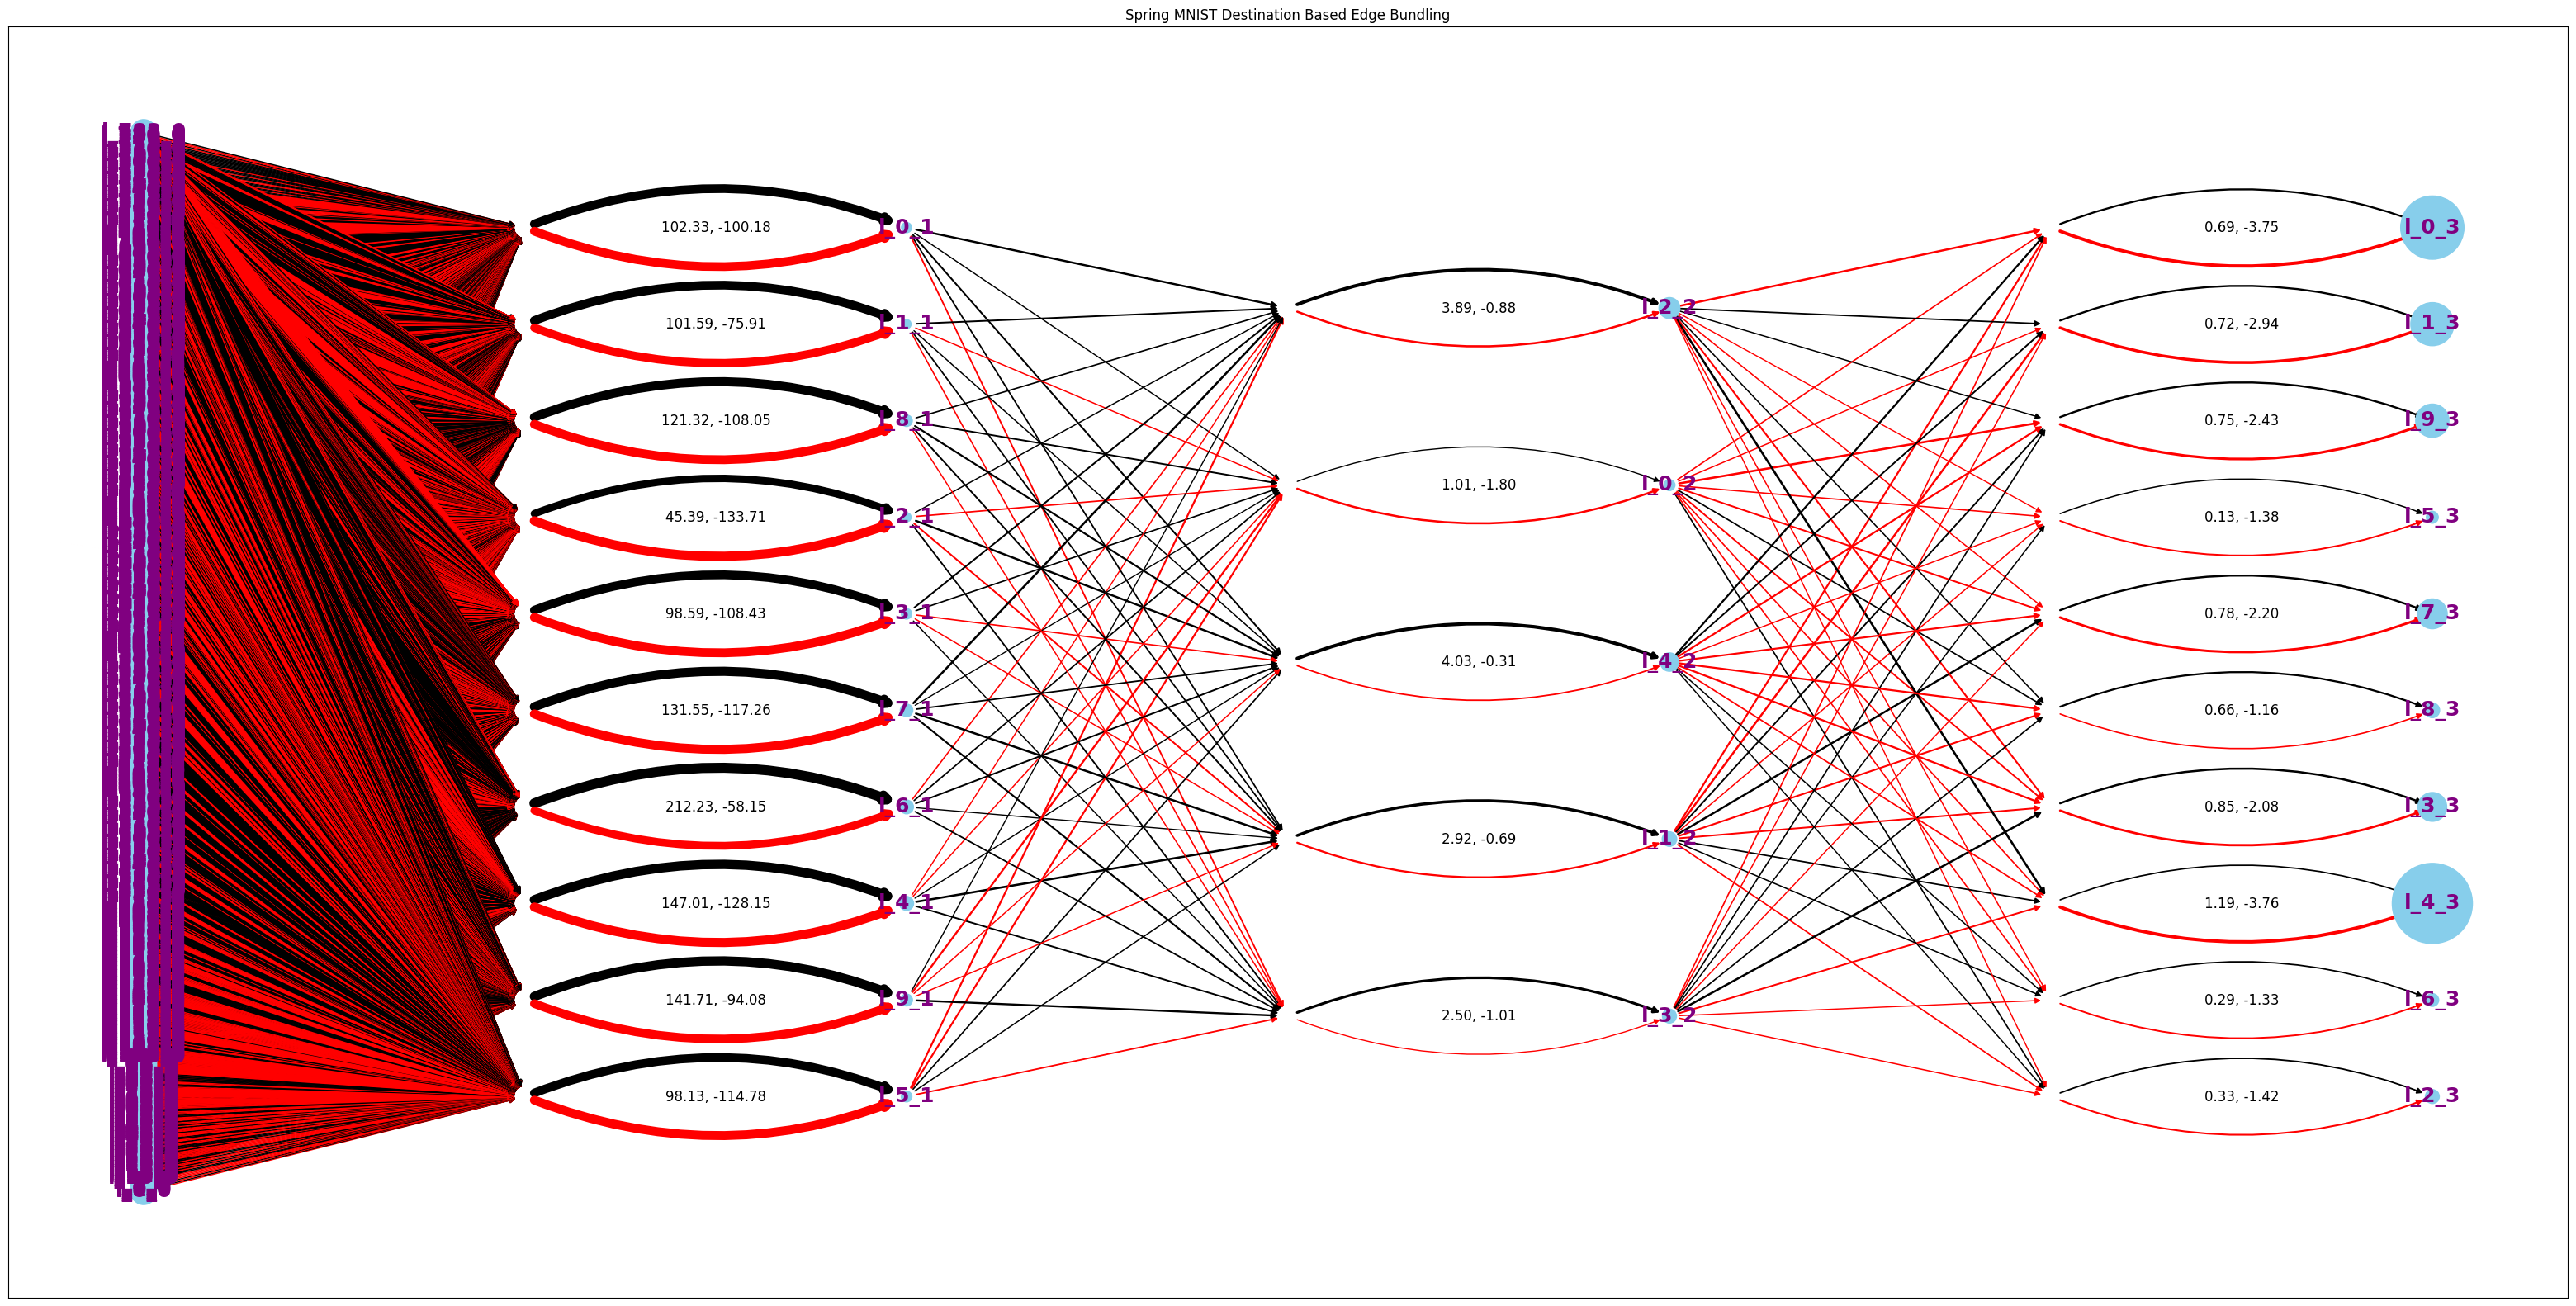

In [26]:

edge_colors = ['black' if G[u][v][key]['weight'] >= 0 else 'red' for u, v, key in G.edges(keys=True)] # Edge colors based on weight
width = [math.log2(abs(G[u][v][key]['weight'])) + 1 if abs(G[u][v][key]['weight']) > 1 else abs(G[u][v][key]['weight']) + 1 for u, v, key in G.edges(keys=True)] # Edge width based on weight
node_list = [node for node in G.nodes() if node[:2] != 'mp']
connectionStyle = []
edge_labels = {}

#for node size = weight
node_size = []
dest_node_size = {}


for u, v, key, d in G.edges(keys=True, data = True):
   #node size = weight
  if v[:2] != 'mp':
    dest_node_size[v] = dest_node_size.get(v, 0) + abs(d['weight'])

  #determines connection style
  if u.split('_')[0] != 'mp': #if source node isn't a mdpt, edge is straight
    connectionStyle.append('arc3')
  else:
    try: # if both a pos and neg edge exist btwn midpt and dest then, pos curves up, and neg curces down
      if G[u][v][0]['weight'] != 0 and G[u][v][1]['weight'] != 0:
        if key == 0:
          connectionStyle.append(f'arc3,rad={-0.20}')
        else:
          connectionStyle.append(f'arc3,rad={0.20}')
    except KeyError as e: # if only a positive or negative edge btwn mdpt and dest, then edge is straight
      connectionStyle.append('arc3')

  # makes edge labels
  if u.split('_')[0] != 'mp': # if not source node isn't a mp then just give typical weights
    edge_labels[(u, v, key)] = f"{G[u][v][key]['weight']:.2f}"
  else:
    try:
      if G[u][v][0]['weight'] != 0 and G[u][v][1]['weight'] != 0:
        # if both outgoing weights of positive and negative give Positive, negative
        edge_labels[(u, v, key)] = f"{G[u][v][0]['weight']:.2f}, {G[u][v][1]['weight']:.2f}"
    except KeyError as e:
      #if only one key give a singular weight
      edge_labels[(u, v, key)] = f"{G[u][v][key]['weight']:.2f}"

#node size = weight
for node in G.nodes():
  if node[:2] != 'mp':
    col = int(node.split('_')[2]) - 1
    if node in dest_node_size.keys():
      node_size.append((dest_node_size[node]/colSize[col] + 1) ** 10 * 10)
    else:
      node_size.append(500)


plt.figure(figsize=(40, 20))

#draws none mdpt nodes, with color and size
nx.draw_networkx_nodes(G, pos=pos, nodelist = node_list, node_size=node_size, node_color='skyblue')

label_pos = {} #makes pos for node labels, to prevent mdpt labeling
for node, coords in pos.items():
  if node.split('_')[0] != 'mp':
    label_pos[node] = np.array([coords[0], coords[1]]) # if not mp gives lable
  else:
    label_pos[node] = np.array([-55000000, -550000000]) # if mp throws the labels way out there because we don't want to see them

# node names
nx.draw_networkx_labels(G, label_pos, font_size=18, font_color='purple', font_weight='bold')



# Draw edges individually with specified connection styles (adds a curve if more than two edges per two nodes)
for (u, v, key), color, style, w in zip(G.edges(keys=True), edge_colors, connectionStyle, width):
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v, key)],
        edge_color=color,
        connectionstyle=style,
        width=w,
        arrows=True
    )

# draws the edge labels
for u, v, key in G.edges(keys=True):
    specific_edge_labels = {(u, v, key): edge_labels[(u, v, key)]}
    row = int(u.split('_')[1])
    index = int(u.split('_')[2])
    if u[:2] == 'mp':
      nx.draw_networkx_edge_labels(G, pos, edge_labels=specific_edge_labels, font_color='black', font_size=12, label_pos = 0.5)
#    else:
#       nx.draw_networkx_edge_labels(G, pos, edge_labels=specific_edge_labels, font_color='black', font_size=12, label_pos = (row + 1) / (colSize[index]+2))

plt.title('Spring MNIST Destination Based Edge Bundling')
plt.show()
